In [70]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

from tinygp import kernels, GaussianProcess


jax.config.update("jax_enable_x64", True)

In [448]:
def model(X, Y, X_pred):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    # noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    # jitter = numpyro.sample("jitter", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # kernel = var * kernels.Matern32(rho)
    kernel = var*kernels.ExpSquared(scale=length)
    gp = GaussianProcess(kernel, X, diag=1e-6 + noise, mean=0)
    numpyro.sample("gp", gp.numpyro_dist(), obs=Y)

    cond_gp = gp.condition(Y, X_pred).gp
    # numpyro.deterministic("pred2", cond_gp.mean)
    # numpyro.deterministic("pred", gp.predict(Y, X_pred))
    numpyro.deterministic("pred", gp.predict(Y, X_pred, return_var=True))
    

# helper function for doing hmc inference
def run_inference(model, args, rng_key, X, Y, X_pred):
    start = time.time()
    kernel = NUTS(model, target_accept_prob=0.9, init_strategy=init_to_median(num_samples=10))
    mcmc = MCMC(
        kernel,
        num_warmup=args['num_warmup'],
        num_samples=args['num_samples'],
        num_chains=args['num_chains'],
        thinning=args['thinning'],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(rng_key, X, Y, X_pred)
    mcmc.print_summary()
    print("\nMCMC elapsed time:", time.time() - start)
    return mcmc.get_samples()


<Axes: >

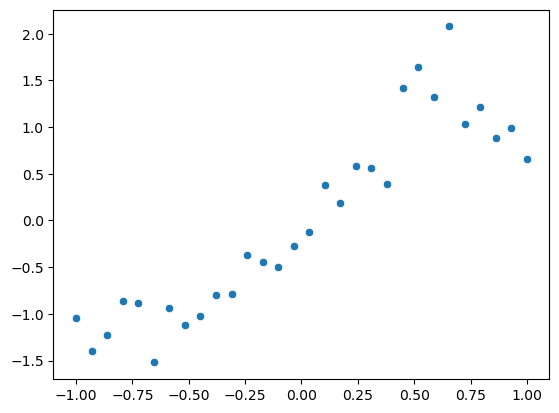

In [449]:
# test data

N = 30
sigma_obs = 0.15
N_test = 400

def y_func(X_pred):
    return(X_pred + 0.2 * jnp.power(X_pred, 2.0) + 0.5 * jnp.power(0.5 + X_pred, 2.0) * jnp.sin(4.0 * X_pred))
    

np.random.seed(0)
X = jnp.linspace(-1, 1, N)
X_pred = jnp.linspace(-1.3, 1.3, N_test)
Y_true = y_func(X_pred)
Y_true -= jnp.mean(Y_true)
Y_true /= jnp.std(Y_true)

Y = y_func(X)
Y += sigma_obs * np.random.randn(N)
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

assert X.shape == (N,)
assert Y.shape == (N,)

sns.scatterplot(x=X,y=Y)


In [450]:
args = {
    'num_samples': 1000,
    'num_warmup': 1000,
    'num_chains': 1,
    'thinning': 2,
    'num_data': 25,
    'device': 'cpu',
    'init_strategy': 'median'
}

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y, X_pred)


sample: 100%|██████████| 2000/2000 [00:02<00:00, 973.63it/s, 3 steps of size 4.54e-01. acc. prob=0.95] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.53      0.17      0.50      0.30      0.83    399.40      1.00
   kernel_noise      0.08      0.02      0.08      0.05      0.12    440.72      1.00
     kernel_var      1.94      2.86      1.06      0.19      4.53    322.62      1.00

Number of divergences: 0

MCMC elapsed time: 3.100471019744873


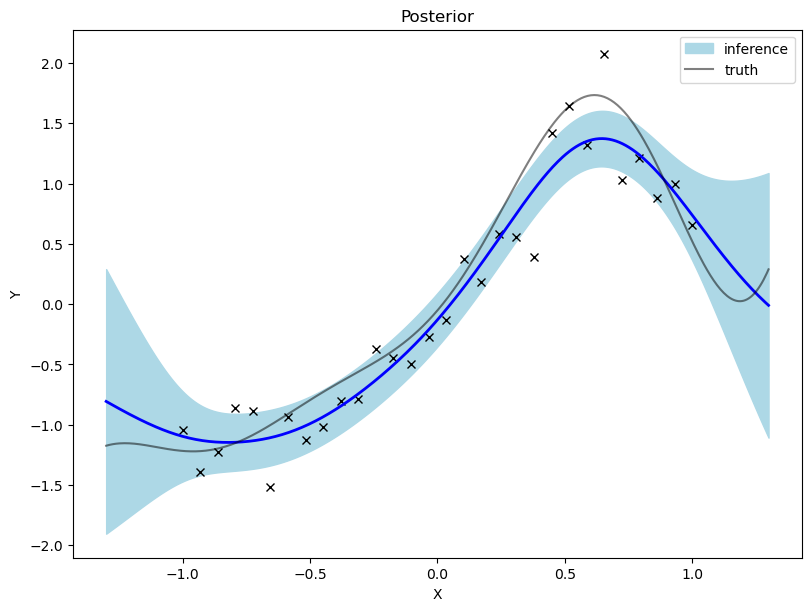

In [451]:
posterior_means = np.mean(samples["pred"][0], axis=0)
vars = np.mean(samples["pred"][1], axis=0) # (maybe sus, TODO: check later)
lower = posterior_means - 2*jnp.sqrt(vars) # 2* std dev ~ 95 CI
upper = posterior_means + 2*jnp.sqrt(vars)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, "kx")
# plot 90% confidence level of predictions
ax.fill_between(X_pred, lower, upper, color="lightblue", label='inference')
# plot mean prediction
ax.plot(X_pred, posterior_means, "blue", ls="solid", lw=2.0)
# plot truth
ax.plot(X_pred, Y_true, "k", lw=1.5, alpha=0.5, label="truth")
ax.set(xlabel="X", ylabel="Y", title="Posterior")
plt.legend()

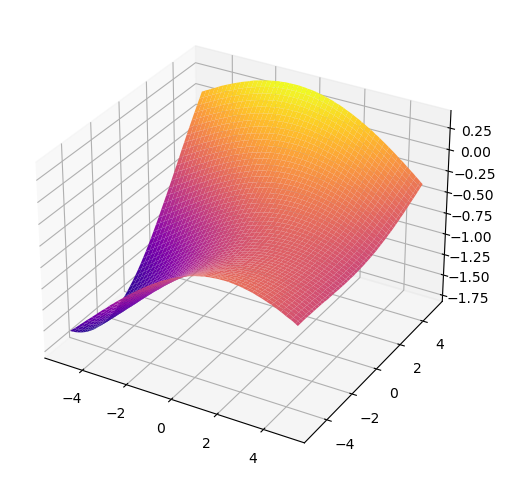

In [401]:
# simulate 2d data from GP

from scipy.stats import multivariate_normal, uniform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

x_grid, y_grid = jnp.linspace(-5, 5, 100), np.linspace(-5, 5, 50)
x_2d, y_2d = jnp.meshgrid(x_grid, y_grid)
X_true = jnp.vstack((x_2d.flatten(), y_2d.flatten())).T

kernel = 2*kernels.ExpSquared(scale=8)
gp = GaussianProcess(kernel, X_true, diag=1e-6)
Y_true = gp.sample(jax.random.PRNGKey(4), shape=(1,))


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

Y_reshape = jnp.reshape(Y_true, (50,100))
ax.plot_surface(x_2d, y_2d, Y_reshape, cmap=cm.plasma)

plt.show()

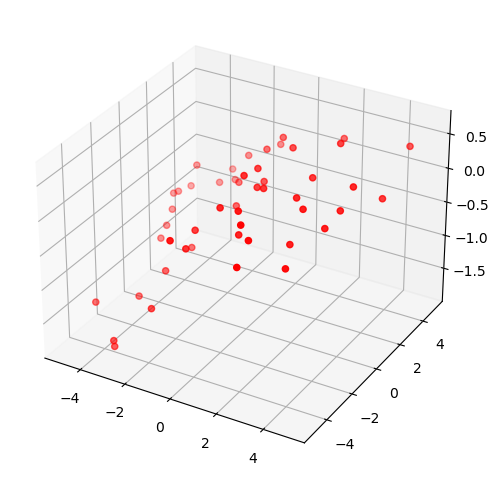

In [404]:
N = 50
sigma_obs = 0.15

np.random.seed(0)
x1_indices = np.random.choice(np.arange(0, x_grid.shape[0]), size=N, replace=False)
x2_indices = np.random.choice(np.arange(0, y_grid.shape[0]), size=N, replace=False)

X = jnp.vstack((x_grid[x1_indices], y_grid[x2_indices])).T
Y = Y_reshape[x1_indices, x2_indices]
Y += sigma_obs * np.random.randn(N)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y, c='red')


In [403]:
samples = run_inference(model, args, rng_key, X, Y, X_true)

sample: 100%|██████████| 2000/2000 [00:04<00:00, 490.37it/s, 3 steps of size 4.47e-01. acc. prob=0.95] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      2.53      0.14      2.52      2.32      2.77    311.09      1.00
   kernel_noise      0.00      0.00      0.00      0.00      0.00    419.49      1.00
     kernel_var      0.33      0.12      0.31      0.17      0.51    303.45      1.00

Number of divergences: 0

MCMC elapsed time: 9.733407974243164


<Figure size 800x600 with 0 Axes>

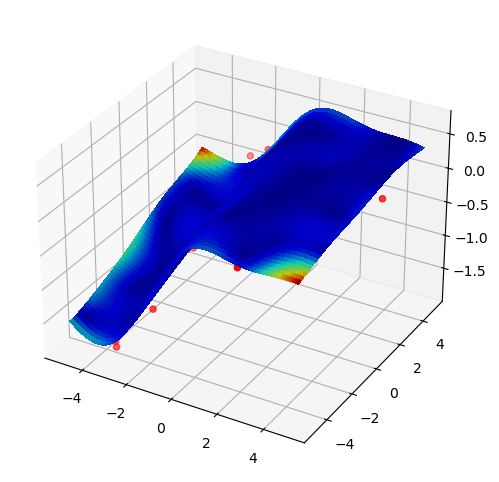

In [441]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.sqrt(np.mean(samples["pred"][1], axis=0))
post_means.shape

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()